# Probabilistic Roadmap


In this notebook you'll expand on previous random sampling exercises by creating a graph from the points and running A*.

1. Load the obstacle map data
2. Sample nodes (use KDTrees here)
3. Connect nodes (use KDTrees here)
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data for you and provide a template for visualization.

In [1]:
# Again, ugly but we need the latest version of networkx!
# This sometimes fails for unknown reasons, please just 
# "reset and clear output" from the "Kernel" menu above 
# and try again!
import pkg_resources
try:
    pkg_resources.require("networkx==2.1")
    import networkx as nx
except:
    import sys
    !{sys.executable} -m pip install -I networkx==2.1
    pkg_resources.require("networkx==2.1")
    import networkx as nx

In [2]:
nx.__version__ # should be 2.1

'2.1'

In [3]:
import time
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from shapely.geometry import box as Box
from queue import PriorityQueue
from sklearn.neighbors import KDTree
import pdb
import chaospy

%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = 14, 14

## Step 1 - Load Data

In [5]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


## Step 2 - Sample Points


You may want to limit the z-axis values.

### Step 2.a - Generate random points

Create a random set of points

A question to answer here is whether it is more efficient to:
* create a kdtree of polygon centers and a dict of center : halfwidth key-value pairs and then query the kdtree using the random points 

or if it is more efficient to:

* create a kdtree of randomly sampled points and then walk through the list of polygons to find points that are within a specific radius (using the half-width) of the polygon.

In [6]:
class PolyLibrary:
    def __init__(self, data):
        self._poly_center = []
        self._poly_dict = dict()
        
        
        self._extract_polygons(data)
        
        self._poly_tree = KDTree(self._poly_center)

    @property
    def polygons(self):
        return list(self._poly_dict.values())
    
    def nearest_polys(self, point, num_polys=1):
        ''' This function returns the nearest N polygons to the 2D point '''
        idx = self._poly_tree.query([point], k=num_polys,
                                       return_distance=False)[0]
        polys = []
        for i in idx:
            polys.append(self.__getitem__(i))
            
        return polys
    
    def polys_between(self, p1, p2):
        ''' Given two points, find all of the polygons that could potentially
            be along the line between them.
            We'll do this by calculating the distance between the two points
            and then using that as a search radius for polygons centered 
            around the two points. This will provide more polygons than necessary
            but will be far fewer than checking all of the polygons for collision
            '''
        d = LA.norm(np.array(p2) - np.array(p1))
        idx = self._poly_tree.query_radius([p1[:2], p2[:2]], r=d)
        idx = set(list(idx[0]) + list(idx[1]))
        polys = []
        for i in idx:
            polys.append(self.__getitem__(i))
        
        return polys
        
    def __getitem__(self, idx):
        return self._poly_dict[self._poly_center[idx]]
    
    def _extract_polygons(self, data):
        # This method should return a dictionary with key-value pairs of 
        # polygon_center : shapely polygon

        for i in range(data.shape[0]):
            north, east, alt, d_north, d_east, d_alt = data[i, :]

            # Extract the min & max extents of the obstacle and create a box shaped
            # polygon
            p = Box(north-d_north, east-d_east, 
                    north+d_north, east+d_east)        

            # Compute the height of the polygon
            height = alt+d_alt

            center = (north, east)
            self._poly_dict[center] = (p, height)
            self._poly_center.append(center)

Define a function that takes a list of polygons and checks if a point is within any of them.

In [7]:
def collides(polygons, point):   
    # Determine whether the point collides
    # with any obstacles.    
    for p, h in polygons:
        if p.contains(Point(point)) and point[2] <= h:
            return True
    return False

In [8]:
# Determine the extents of the map:
xmin = np.min(data[:, 0] - data[:, 3])
xmax = np.max(data[:, 0] + data[:, 3])
xrange = xmax - xmin

ymin = np.min(data[:, 1] - data[:, 4])
ymax = np.max(data[:, 1] + data[:, 4])
yrange = ymax - ymin

zmin = 3
# Limit the z axis for the visualization
zmax = 50 # alt. np.max(data[:,2] + data[:,5])
zrange = zmax-zmin

stat_str = "min = {0}, max = {1}, range = {2}\n"

print("X")
print(stat_str.format(xmin, xmax, xrange))

print("Y")
print(stat_str.format(ymin, ymax, yrange))

print("Z")
print(stat_str.format(zmin, zmax, zrange))


X
min = -315.2389, max = 604.7611, range = 920.0

Y
min = -444.2315, max = 475.7685, range = 920.0

Z
min = 3, max = 50, range = 47



In [9]:
def get_point_height(polygons, point):   
    # Determine whether the point collides
    # with any obstacles.    
    for p, h in polygons:
        if p.contains(Point(point)) and point[2] <= h:
            return h + zmin
    return point[2]

1. Extract polygons from the raw data
    1. Create a dictionary of center : (polygon, height) pairs
2. Create a KDTree of polygon centers
3. Create a random-uniform sample of points
4. For each point:
    1. Query the KDTree for the nearest polygon center
    2. Check the point for collision
    3. If no collision, add the point to the list of nodes to keep

In [10]:
# TODO: sample points randomly
# then use KDTree to find nearest neighbor polygon
# and test for collision

# Generate a dictionary of polygons, using the center as the key:
PL = PolyLibrary(data)

# Generate a uniform random sampling of points.
num_samples = 1000
np.random.seed(0)  # Seed random so we always get the same data.
                   # This can be changed later.

# Generate some random 3-dimensional points
#xvals = np.random.uniform(xmin, xmax, num_samples)
#yvals = np.random.uniform(ymin, ymax, num_samples)
#zvals = np.random.uniform(zmin, zmax, num_samples)

#r_vals = np.random.rand(num_samples, 3)
r_vals = chaospy.create_halton_samples(1000, 3)

# r_vals are sampled from the unit cube. Perform an affine transfer
# to the grid coordinates
samples = (np.diag([xrange, yrange, zrange]).dot(r_vals) 
            + np.array([[xmin, ymin, zmin]]).transpose()).transpose().tolist()

In [11]:
t0 = time.time()
nodes = []
for point in samples:
    # Find the nearest polygons:
    #print(point)
    #print(np.reshape(point[0:2],[1, -1]))
    polys = PL.nearest_polys(point[:2])
    h = get_point_height(polys, point)
    nodes.append((point[0], point[1], h))
    #if not collides(polys, point):
    #    nodes.append(point)
time_taken = time.time() - t0
print("Collision checking took {0} seconds ...".format(time_taken))
print("Kept {0} of {1} points".format(len(nodes), len(samples)))
print("Average node coverage area: {0}".format((xrange*yrange)/len(nodes)))
print("Grid center: ({0}, {1})".format(0.5*(xmax+xmin), 0.5*(ymax+ymin)))
print("Sample point center: ({0})".format(np.average(np.array(nodes), axis=0)))
search_radius = ((3*xrange*yrange*zrange)/(4*np.pi))**(1./3)
print("Recommended search radius: {0}".format(search_radius))

Collision checking took 0.09537911415100098 seconds ...
Kept 1000 of 1000 points
Average node coverage area: 846.4
Grid center: (144.76110000000003, 15.768500000000017)
Sample point center: ([144.14477188  14.37188363  47.72765909])
Recommended search radius: 211.768633612737


## Step 3 - Connect Nodes

Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through an obstacle.

NOTE: You can use `LineString()` from the `shapely` library to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths, for instance your `LineString()` with an obstacle `Polygon()`!

In [12]:
def can_connect(p1, p2, poly_lib):
    l = LineString([p1, p2])
    #print(l)
    poly_lib.polys_between(p1,p2)
    for poly, height in poly_lib.polys_between(p1, p2):
        if l.crosses(poly) and min(p1[2], p2[2]) <= height:
            return False
    
    return True

In [13]:
def create_graph(nodes, poly_lib, max_conns=5, min_dist=5):
    g = nx.Graph()
        
    p_tree = KDTree(nodes)
    
    for node in nodes:
        # Here we'll look for the 12 nearest nodes, but only connect
        # up to 'max_conns' of them.
        dist, node_idx = p_tree.query([node], k=15)
        conns = 0
        for idx, d in zip(node_idx[0],dist[0]):
            n2 = nodes[idx]
            if node == n2:
                continue
            if d < min_dist:
                print("skipping node {} due to min dist violation ({:.3} < {})".format(n2, d, min_dist))
                continue
            # Test the node for possible connectedness
            if can_connect(node, n2, poly_lib):
                conns += 1
                g.add_edge(node, n2, weight=LA.norm(np.array(node)-np.array(n2)))
            if conns >= max_conns:
                break
        #if conns < max_conns:
        #    print("For node", node, "only found {0} connections.".format(conns))
    return g

In [14]:
# TODO: connect nodes
# Suggested method
    # 1) cast nodes into a graph called "g" using networkx
    # 2) write a method "can_connect()" that:
        # casts two points as a shapely LineString() object
        # tests for collision with a shapely Polygon() object
        # returns True if connection is possible, False otherwise
    # 3) write a method "create_graph()" that:
        # defines a networkx graph as g = Graph()
        # defines a tree = KDTree(nodes)
        # test for connectivity between each node and 
            # k of it's nearest neighbors
        # if nodes are connectable, add an edge to graph
    # Iterate through all candidate nodes!
    
t0 = time.time()
g = create_graph(nodes, PL, max_conns=3, min_dist=5)
time_taken = time.time() - t0
print("Graph creation took {0} seconds ...".format(time_taken))
print("Graph has {0} edges.".format(len(g.edges)))


Graph creation took 2.9045608043670654 seconds ...
Graph has 1713 edges.


## Step 4 - Visualize Graph

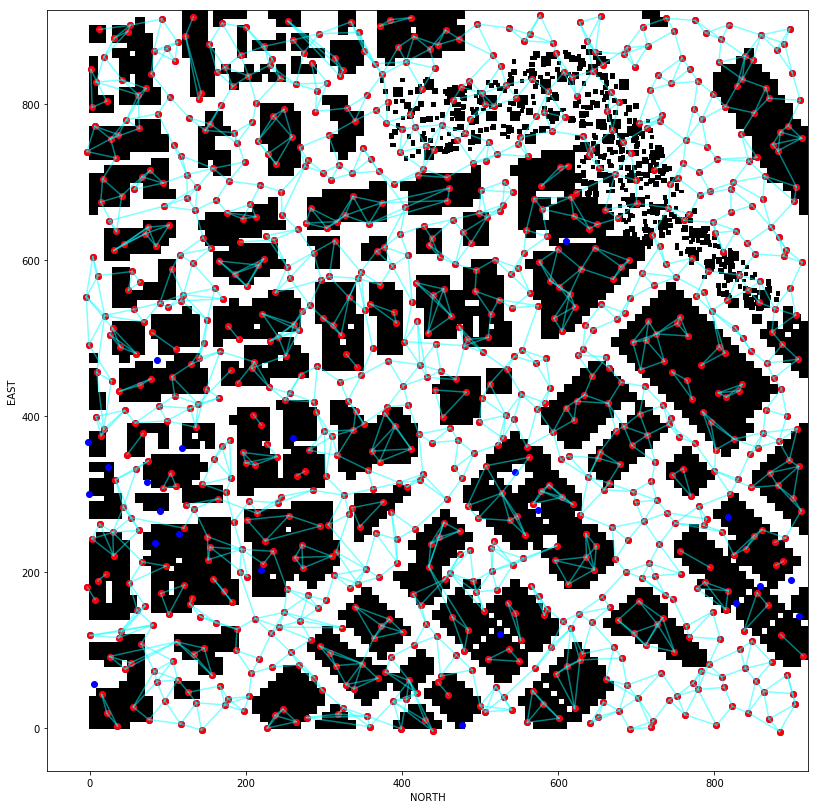

In [15]:
# Create a grid map of the world
from udacity_helpers.grid import create_grid
# This will create a grid map at 1 m above ground level
grid = create_grid(data, 1, 1)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'cyan' , alpha=0.5)

# Draw all nodes connected or not in blue
for n1 in nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()


## Step 5 - Define Heuristic

In [16]:
def heuristic(n1, n2):
    return LA.norm(np.array(n1) - np.array(n2))

## Step 6 - Complete A*

In [17]:
def a_star(graph, h, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph.neighbors(current_node):
                branch_cost = current_cost + graph.get_edge_data(current_node,next_node)['weight']
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    branch[next_node] = (branch_cost, current_node)
                    queue.put((queue_cost, next_node))
             
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost



In [18]:
start = list(g.nodes)[10]
k = np.random.randint(len(g.nodes))
print(k, len(g.nodes))
goal = list(g.nodes)[k]

684 978


In [23]:
print("start: {}".format(start))
print("goal:  {}".format(goal))

start: (-281.9967125, 383.6422997256516, 14.671040000000001)
goal:  (235.5032875, 417.7163737997256, 9.031039999999999)


In [19]:
path, cost = a_star(g, heuristic, start, goal)
print(len(path), path)

Found a path.
26 [(-281.9967125, 383.6422997256516, 14.671040000000001), (-257.7389, 373.54627777777773, 33.08), (-244.2623375, 370.18093712848645, 38.13344), (-228.0904625, 353.35423388203003, 16.836800000000004), (-195.7467125, 368.4982668038408, 46.25504), (-160.70765, 358.40224485596696, 26.7632), (-179.5748375, 324.74883836305435, 24.59744), (-144.535775, 307.92213511659793, 3.3008), (-139.14515, 297.8261131687242, 8.7152), (-114.8873375, 284.36475057155917, 40.84064), (-98.7154625, 277.6340692729766, 30.3728), (-74.45765, 290.2540967078189, 47.06720000000001), (-47.504525, 310.4461406035664, 36.2384), (-25.942025, 340.73420644718783, 18.190399999999997), (-9.770150000000001, 381.1182942386831, 10.9712), (9.097037499999999, 391.21431618655697, 23.604800000000004), (41.4407875, 406.35834910836763, 7.903040000000001), (68.3939125, 423.18505235482394, 42.19424000000001), (98.04235, 426.5503930041151, 15.4832), (124.995475, 446.7424368998627, 4.6544), (138.4720375, 436.64641495198896,

## Step 7 - Visualize Path

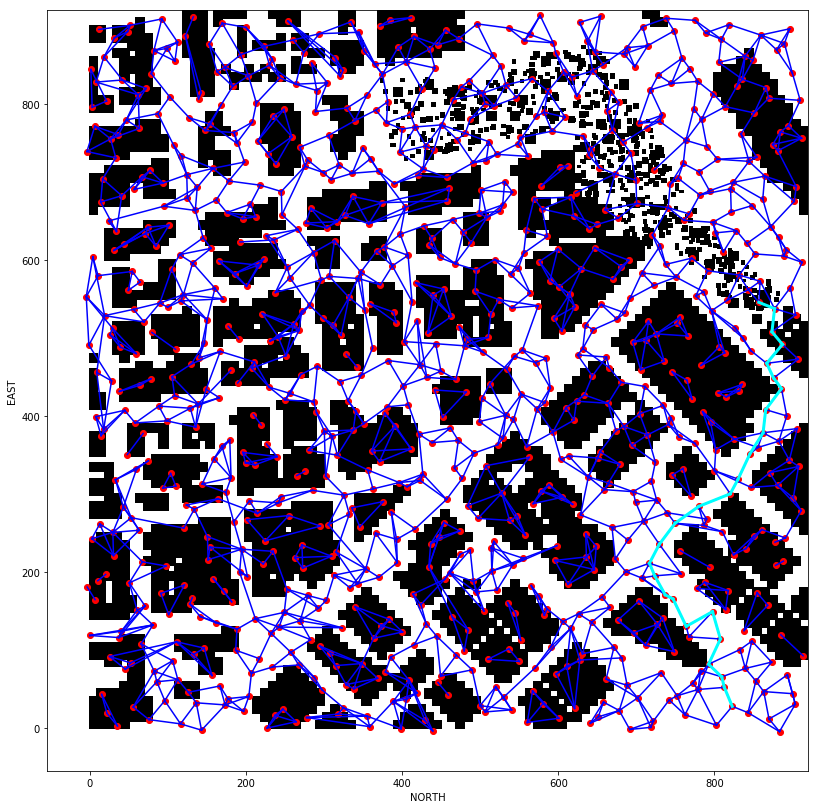

In [20]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

# Add code to visualize path here
nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'blue')
    
# TODO: add code to visualize the path
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], 
             [n1[0] - nmin, n2[0] - nmin], 
             'cyan', linewidth=3)


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

In [21]:
nx.number_connected_components(g)

53

(1000, 3)


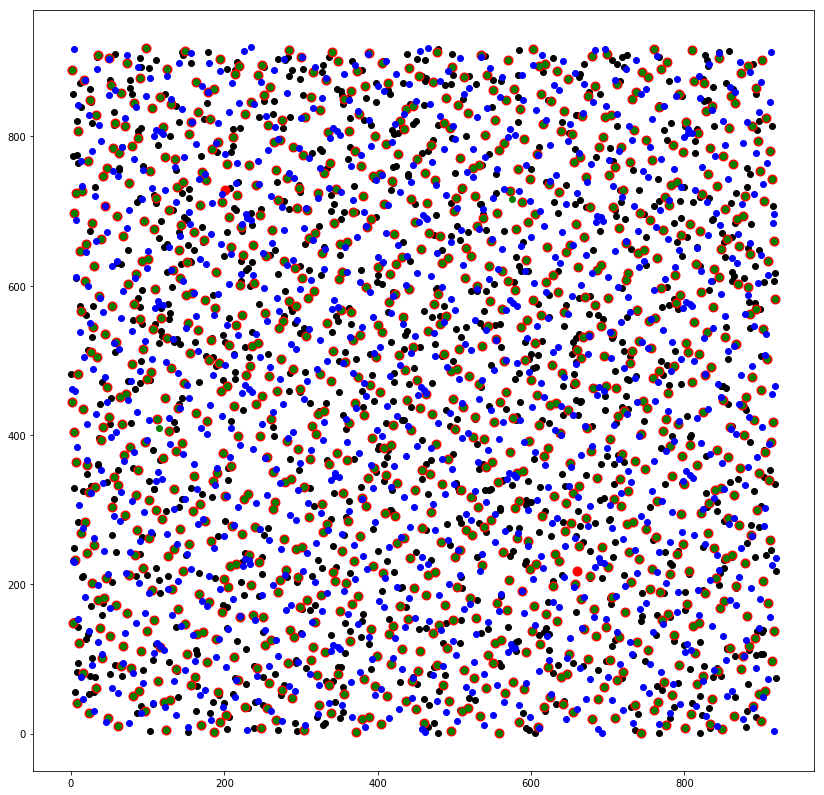

In [22]:
import chaospy
n_samps = 1000
dims = 3
f = chaospy.create_halton_samples(n_samps, dims).transpose()
h = chaospy.create_hammersley_samples(n_samps, dims).transpose()
k = chaospy.create_korobov_samples(n_samps, dims).transpose()
s = chaospy.create_sobol_samples(n_samps, dims).transpose()
n = np.random.rand(n_samps, dims)
print(n.shape)
# plot obstacle map
#plt.imshow(grid, cmap='Greys', origin='lower')

plt.scatter(n[:,0]*xrange, n[:,1]*yrange, c='black')
# draw nodes
plt.scatter(f[:,0]*xrange, f[:,1]*yrange, c='red', linewidths=4)
plt.scatter(h[:,0]*xrange, h[:,1]*yrange, c='green', linewidths=1)
#plt.scatter(k[:,0]*xrange, k[:,1]*yrange, c='cyan')
plt.scatter(s[:,0]*xrange, s[:,1]*yrange, c='blue')



plt.show()

[solution](/notebooks/Probabilistic-Roadmap-Solution.ipynb)